In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import os
import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from keras import regularizers
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img

from sklearn.metrics import classification_report, confusion_matrix


In [3]:
train_dir = 'C:/Users/kunal/OneDrive/Desktop/Expression Dataset/train/'
test_dir = 'C:/Users/kunal/OneDrive/Desktop/Expression Dataset/test/'

row = 48
col = 48
classes = len(os.listdir('C:/Users/kunal/OneDrive/Desktop/Expression Dataset/train/'))

In [4]:
print("Train Set :")

train_count = []
for folder in os.listdir(train_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(train_dir+folder)), "image")
    train_count.append(len(os.listdir(train_dir+folder)))
    
print()

test_count = []
print("Test Set :")
for folder in os.listdir(test_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(test_dir+folder)), "images")
    test_count.append(len(os.listdir(test_dir+folder)))


Train Set :
angry folder contains		 3995 image
disgust folder contains		 436 image
fear folder contains		 4097 image
happy folder contains		 7215 image
neutral folder contains		 4965 image
sad folder contains		 4830 image
surprise folder contains		 3171 image

Test Set :
angry folder contains		 958 images
disgust folder contains		 111 images
fear folder contains		 1024 images
happy folder contains		 1774 images
neutral folder contains		 1233 images
sad folder contains		 1247 images
surprise folder contains		 831 images


In [29]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:

class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']

# Assuming you have a generator object called 'train_generator'
img, label = next(training_set)


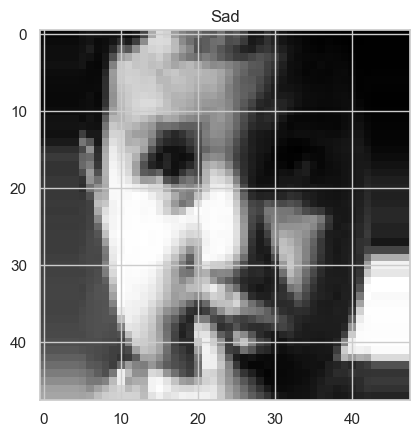

In [8]:
import random



i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

In [11]:
model = tf.keras.models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(48,48,1)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=(3, 3),padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [12]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [15]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = model.fit(x=training_set,
                  validation_data=test_set,
                  epochs=25,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)

Epoch 1/25
448/448 [==============================] - ETA: 0s - loss: 2.9945 - accuracy: 0.2777
Epoch 1: val_loss improved from inf to 7.11064, saving model to ferNet.h5


C:\Users\kunal\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 997s 2s/step - loss: 2.9945 - accuracy: 0.2777 - val_loss: 7.1106 - val_accuracy: 0.1878 - lr: 0.0010
Epoch 2/25
448/448 [==============================] - ETA: 0s - loss: 1.8191 - accuracy: 0.3434
Epoch 2: val_loss improved from 7.11064 to 1.77358, saving model to ferNet.h5
448/448 [==============================] - 485s 1s/step - loss: 1.8191 - accuracy: 0.3434 - val_loss: 1.7736 - val_accuracy: 0.3417 - lr: 0.0010
Epoch 3/25
448/448 [==============================] - ETA: 0s - loss: 1.6988 - accuracy: 0.3796
Epoch 3: val_loss improved from 1.77358 to 1.70322, saving model to ferNet.h5
448/448 [==============================] - 484s 1s/step - loss: 1.6988 - accuracy: 0.3796 - val_loss: 1.7032 - val_accuracy: 0.3898 - lr: 0.0010
Epoch 4/25
448/448 [==============================] - ETA: 0s - loss: 1.6559 - accuracy: 0.4097
Epoch 4: val_loss improved from 1.70322 to 1.57615, saving model to ferNet.h5
448/448 [==============================] - 

In [16]:
model.save("model_trained.h5")

In [26]:
import os
import numpy as np
import cv2
from keras.models import load_model
from PIL import Image

home_folder = 'C:/Users/kunal/OneDrive/Desktop/Expression Dataset'
test_folder = os.path.join(home_folder, 'test')
train_folder = os.path.join(home_folder, 'train')

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".JPG"):
            img = Image.open(os.path.join(folder_path, filename))
            if img is not None:
                images.append(img)
    return images

test_images = load_images_from_folder(test_folder)
train_images = load_images_from_folder(train_folder)

test_data = np.array([np.array(img) for img in test_images])
train_data = np.array([np.array(img) for img in train_images])

# Loading trained model
my_model = load_model('model_trained.h5', compile=False)

# Define the emotion labels
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']

# Initialize the camera
cap = cv2.VideoCapture(0)  
frame_count = 0  # Counter for frames
detected_emotion = None  

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
        print("Failed to grab frame.")
        break

    # Preprocess the frame 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        face_roi = gray[y:y + h, x:x + w]
        face_img = cv2.resize(face_roi, (48, 48))
        face_img = face_img / 255.0  # Normalize

        # Make predictions using your model
        predictions = my_model.predict(np.array([face_img.reshape(48, 48, 1)]))
        detected_emotion = class_labels[np.argmax(predictions)]

        # Draw a rectangle around the detected face and display the emotion
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, detected_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    cv2.imshow("webcam", frame)
    
    if frame_count == 25:  # Close the webcam after 1 seconds (assuming 25 frames per second)
        break

    frame_count += 1
    cv2.waitKey(1)

# Release the camera
cap.release()
cv2.destroyAllWindows()

# Access the detected emotion after the webcam closes
print("Detected Emotion:", detected_emotion)


1/1 [==============================] - 0s 49ms/step
Detected Emotion: Sad


In [23]:
import pandas as pd
mood_music=pd.read_csv(r"C:\Users\kunal\Downloads\archive (3)\data_moods.csv")

In [24]:
mood_music=mood_music[['name', 'artist', 'mood']]
mood_music.head()

,name,artist,mood
0,1999,Prince,Happy
1,23,Blonde Redhead,Sad
2,9 Crimes,Damien Rice,Sad
3,99 Luftballons,Nena,Happy
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic


In [25]:
#selecting music according to moods

if (detected_emotion=='Angry' or detected_emotion=='Disgust' or detected_emotion=='Fear'):
    filter1=mood_music['mood']=='Calm' #Filtering according to 'mood' column in dataset
    f1=mood_music.where(filter1)
    f1=f1.dropna() #dropping rows that are empty
    f2=f1.sample(n=5) #Displaying 5 songs
    f2.reset_index(inplace=True)
    display(f2)
if (detected_emotion=='Happy' or detected_emotion=='Neutral'):
    filter1=mood_music['mood']=='Happy' #Filtering according to 'mood' column in dataset
    f1=mood_music.where(filter1)
    f1=f1.dropna() #dropping rows that are empty
    f2=f1.sample(n=5) #Displaying 5 songs
    f2.reset_index(inplace=True)
    display(f2)
    
if (detected_emotion=='Sad'):
    filter1=mood_music['mood']=='Sad' #Filtering according to 'mood' column in dataset
    f1=mood_music.where(filter1)
    f1=f1.dropna() #dropping rows that are empty
    f2=f1.sample(n=5) #Displaying 5 songs
    f2.reset_index(inplace=True)
    display(f2)
    
if (detected_emotion=='Surprised'):
    filter1=mood_music['mood']=='Energetic' #Filtering according to 'mood' column in dataset
    f1=mood_music.where(filter1)
    f1=f1.dropna() #dropping rows that are empty
    f2=f1.sample(n=5) #Displaying 5 songs
    f2.reset_index(inplace=True)
    display(f2)
    


,index,name,artist,mood
0,481,Simple Song,Passenger,Sad
1,598,Unmade,Thom Yorke,Sad
2,30,Andromeda,Weyes Blood,Sad
3,459,Sad Corny Fuck,JP Saxe,Sad
4,669,blue,Kamal.,Sad
